In [1]:
# Install packages not included in Google Colab
!pip install geopandas 
# Import packages
import requests # For getting data from the CensusAPI
import sys  # For checking version of python for replication
import pandas as pd # For reading, writing and wrangling data
import geopandas as gpd # For creating maps
import folium as fm # For creating the final HTML map complete with OSM (Open Street Map) basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 
     |████████████████████████████████| 16.7 MB 341 kB/s 
     |████████████████████████████████| 6.3 MB 49.7 MB/s 


In [2]:
# Display package versions - important information for replication
print("Python Version     ", sys.version)
print("requests version:    ", requests.__version__)
print("pandas version:    ", pd.__version__)
print("geopandas version:    ", gpd.__version__)
print("folium version:    ", fm.__version__)

Python Version      3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
requests version:     2.23.0
pandas version:     1.3.5
geopandas version:     0.10.2
folium version:     0.12.1.post1


In [3]:
# It should look like this -> ftp://ftp2.census.gov/geo/tiger/TIGER2010/TRACT/2000/tl_2010_21_tract00.zip
# Try pasting the link address below this line
'ftp://ftp2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip'

'ftp://ftp2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip'

In [4]:
!wget ftp://ftp2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip

--2022-08-22 15:52:00--  ftp://ftp2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_06_tract.zip
           => ‘tl_2019_06_tract.zip’
Resolving ftp2.census.gov (ftp2.census.gov)... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp2.census.gov (ftp2.census.gov)|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/tiger/TIGER2019/TRACT ... done.
==> SIZE tl_2019_06_tract.zip ... 29388806
==> PASV ... done.    ==> RETR tl_2019_06_tract.zip ... done.
Length: 29388806 (28M) (unauthoritative)

tl_2019_06_tract.zi 100%[===================>]  28.03M   262KB/s    in 69s     

2022-08-22 15:53:10 (416 KB/s) - ‘tl_2019_06_tract.zip’ saved [29388806]



In [ ]:
'ftp://ftp2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip'

In [5]:
!wget ftp://ftp2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip

--2022-08-22 16:02:24--  ftp://ftp2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip
           => ‘tl_2019_us_county.zip’
Resolving ftp2.census.gov (ftp2.census.gov)... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp2.census.gov (ftp2.census.gov)|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/tiger/TIGER2019/COUNTY ... done.
==> SIZE tl_2019_us_county.zip ... 79237324
==> PASV ... done.    ==> RETR tl_2019_us_county.zip ... done.
Length: 79237324 (76M) (unauthoritative)

tl_2019_us_county.z 100%[===================>]  75.57M   486KB/s    in 2m 35s  

2022-08-22 16:04:59 (500 KB/s) - ‘tl_2019_us_county.zip’ saved [79237324]



In [6]:
ca_tracts = gpd.read_file('/content/tl_2019_06_tract.shp')

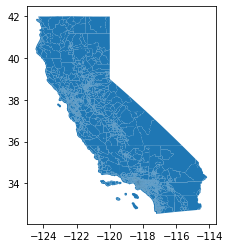

In [9]:
ca_tracts.plot()

In [10]:
# The built out request for the URL  https://api.census.gov/data/2010/dec/sf1?get=LSAD_NAME,P001001&for=tract:*&in=state:06
HOST = "https://api.census.gov/data"
year = "2010"
dataset = "dec/sf1"
base_url = "/".join([HOST, year, dataset])
predicates = {}
get_vars = ["LSAD_NAME", "P001001"]
predicates["get"] = ",".join(get_vars)
predicates["for"] = "tract:*"
predicates["in"] = "state:06"
r = requests.get(base_url, params=predicates)

In [11]:
print(r.json()[0])

['LSAD_NAME', 'P001001', 'state', 'county', 'tract']


In [12]:
# Create user friendly column names
tract_name = ["tract_name", "tract_pop", "state_fips", "county_fips", "tract_fips"]
# Reading the json into pandas df
tractdf = pd.DataFrame(columns=tract_name, data=r.json()[1:])
# Changing data types to integer
tractdf["tract_pop"] = tractdf["tract_pop"].astype(int)

tractdf.head()

,tract_name,tract_pop,state_fips,county_fips,tract_fips
0,Census Tract 4340.04,2796,06,037,434004
1,Census Tract 4600,4851,06,037,460000
2,Census Tract 4602,5315,06,037,460200
3,Census Tract 4603.01,4638,06,037,460301
4,Census Tract 4603.02,4442,06,037,460302


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [13]:
# Using .loc to select by attributes for Census Tracts that match Boone County's fips code
# Use .copy() to prevent hidden chaining -> https://www.dataquest.io/blog/settingwithcopywarning/
onecounty_tractdf = tractdf.loc[tractdf['county_fips'] == '037'].copy()
onecounty_tractdf

,tract_name,tract_pop,state_fips,county_fips,tract_fips
0,Census Tract 4340.04,2796,06,037,434004
1,Census Tract 4600,4851,06,037,460000
2,Census Tract 4602,5315,06,037,460200
3,Census Tract 4603.01,4638,06,037,460301
4,Census Tract 4603.02,4442,06,037,460302
...,...,...,...,...,...
7739,Census Tract 9302,546,06,037,930200
7740,Census Tract 9303.01,886,06,037,930301
7762,Census Tract 9304.01,2471,06,037,930401
7763,Census Tract 9800.01,0,06,037,980001


In [14]:
onecounty_tractdf['tract_fips'] = onecounty_tractdf['tract_fips'].str.ljust(6,'0')

In [17]:
onecounty_tractdf['geoid'] = onecounty_tractdf['state_fips'] + onecounty_tractdf['county_fips'] + onecounty_tractdf['tract_fips']

In [18]:
onecounty_tractdf

,tract_name,tract_pop,state_fips,county_fips,tract_fips,geoid
0,Census Tract 4340.04,2796,06,037,434004,06037434004
1,Census Tract 4600,4851,06,037,460000,06037460000
2,Census Tract 4602,5315,06,037,460200,06037460200
3,Census Tract 4603.01,4638,06,037,460301,06037460301
4,Census Tract 4603.02,4442,06,037,460302,06037460302
...,...,...,...,...,...,...
7739,Census Tract 9302,546,06,037,930200,06037930200
7740,Census Tract 9303.01,886,06,037,930301,06037930301
7762,Census Tract 9304.01,2471,06,037,930401,06037930401
7763,Census Tract 9800.01,0,06,037,980001,06037980001


In [19]:
onecounty_tractdf.count()

tract_name     2346
tract_pop      2346
state_fips     2346
county_fips    2346
tract_fips     2346
geoid          2346
dtype: int64

In [22]:
ca_tracts.info

<bound method DataFrame.info of      STATEFP COUNTYFP TRACTCE        GEOID     NAME              NAMELSAD  \
0         06      037  139301  06037139301  1393.01  Census Tract 1393.01   
1         06      037  139302  06037139302  1393.02  Census Tract 1393.02   
2         06      037  139502  06037139502  1395.02  Census Tract 1395.02   
3         06      037  139600  06037139600     1396     Census Tract 1396   
4         06      037  139701  06037139701  1397.01  Census Tract 1397.01   
...      ...      ...     ...          ...      ...                   ...   
8052      06      001  443001  06001443001  4430.01  Census Tract 4430.01   
8053      06      001  443002  06001443002  4430.02  Census Tract 4430.02   
8054      06      001  443102  06001443102  4431.02  Census Tract 4431.02   
8055      06      001  443301  06001443301  4433.01  Census Tract 4433.01   
8056      06      037  137501  06037137501  1375.01  Census Tract 1375.01   

      MTFCC FUNCSTAT    ALAND  AWATER     I

In [23]:
# Join the shapefile and the CensusAPI dataset together
attr_joined = pd.merge(ca_tracts, onecounty_tractdf, left_on='GEOID', right_on='geoid')
# Check that all 2345 Census Tracts joined
attr_joined.count()

STATEFP        2345
COUNTYFP       2345
TRACTCE        2345
GEOID          2345
NAME           2345
NAMELSAD       2345
MTFCC          2345
FUNCSTAT       2345
ALAND          2345
AWATER         2345
INTPTLAT       2345
INTPTLON       2345
geometry       2345
tract_name     2345
tract_pop      2345
state_fips     2345
county_fips    2345
tract_fips     2345
geoid          2345
dtype: int64

In [24]:
attr_joined.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,tract_name,tract_pop,state_fips,county_fips,tract_fips,geoid
0,06,037,139301,06037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57148 34.1...",Census Tract 1393.01,4462,06,037,139301,06037139301
1,06,037,139302,06037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54073 34.18019, -118.54070 34.1...",Census Tract 1393.02,4422,06,037,139302,06037139302
2,06,037,139502,06037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1...",Census Tract 1395.02,3007,06,037,139502,06037139502
3,06,037,139600,06037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51858 34.15858, -118.51858 34.1...",Census Tract 1396,4633,06,037,139600,06037139600
4,06,037,139701,06037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50848 34.1...",Census Tract 1397.01,4920,06,037,139701,06037139701


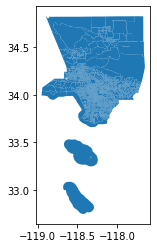

In [25]:
attr_joined.plot()

In [26]:
# Check the original CRS information
attr_joined.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

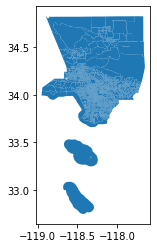

In [27]:
ca_prj=attr_joined.to_crs(epsg=4326)
ca_prj.plot()

In [29]:
ca_prj['tract_pop'] = ca_prj['tract_pop'].astype(int)

check = ca_prj.groupby('TRACTCE')['tract_pop'].sum()

check.head()

TRACTCE
101110    4731
101122    3664
101210    5990
101220    3363
101300    4199
Name: tract_pop, dtype: int64

In [33]:
ca_prj.bounds.head()

,minx,miny,maxx,maxy
0,-118.571496,34.172113,-118.540704,34.187158
1,-118.540734,34.173154,-118.536003,34.180249
2,-118.532245,34.157874,-118.518570,34.171433
3,-118.518585,34.155391,-118.501077,34.171086
4,-118.509800,34.144359,-118.483615,34.170353


In [34]:
# What location should the map be centered on?
center_x = (ca_prj.bounds.minx.mean() + ca_prj.bounds.maxx.mean())/2
center_y = (ca_prj.bounds.miny.mean() + ca_prj.bounds.maxy.mean())/2
print(f'The center of the data file is located at {center_x} {center_y}')

The center of the data file is located at -118.25227698379531 34.065441963113


In [38]:
map = fm.Map(location=[center_y, center_x], zoom_start=10)

# Add Study Area Block Groups to Map
fm.Choropleth(
    geo_data = ca_prj,
    data=ca_prj,
    columns=['tract_pop','ALAND'],
    key_on= 'feature.properties.tract_pop',
    fill_color='YlGnBu',
    name = 'Population Density',
    legend_name='Population Density'
).add_to(map)
map

Output hidden; open in https://colab.research.google.com to view.

In [43]:
# Check to see if the population of the Census Tracts in Boone County adds up
# First change the data type to integer
ca_prj['tract_pop'] = ca_prj['tract_pop'].astype(int)

check = ca_prj.groupby('TRACTCE')['tract_pop'].sum()

check.head()

TRACTCE
101110    4731
101122    3664
101210    5990
101220    3363
101300    4199
Name: tract_pop, dtype: int64

In [58]:
# Create a new column for Census Tract area in square Kilometers

ca_prj['AreaLandKM2'] = (ca_prj['ALAND'] * .000001)

ca_prj[['geoid','TRACTCE','ALAND','AWATER','AreaLandKM2']].head()

,geoid,TRACTCE,ALAND,AWATER,AreaLandKM2
0,06037139301,139301,2865657,0,2.865657
1,06037139302,139302,338289,0,0.338289
2,06037139502,139502,1047548,0,1.047548
3,06037139600,139600,2477482,0,2.477482
4,06037139701,139701,3396396,2411,3.396396


In [59]:
check_km2 = ca_prj.groupby('TRACTCE')['AreaLandKM2'].sum()

check_km2.head()

TRACTCE
101110    1.142401
101122    2.644045
101210    0.650690
101220    0.698886
101300    2.581214
Name: AreaLandKM2, dtype: float64

In [60]:

ca_prj['ppl_perKM2']=(ca_prj['tract_pop']/ca_prj['AreaLandKM2'])
ca_prj[['geoid','TRACTCE','tract_pop','AreaLandKM2','ppl_perKM2']].head(16)

,geoid,TRACTCE,tract_pop,AreaLandKM2,ppl_perKM2
0,06037139301,139301,4462,2.865657,1557.060039
1,06037139302,139302,4422,0.338289,13071.663578
2,06037139502,139502,3007,1.047548,2870.512855
3,06037139600,139600,4633,2.477482,1870.043859
4,06037139701,139701,4920,3.396396,1448.594334
5,06037139801,139801,3539,3.665744,965.424754
6,06037143400,143400,5881,1.738504,3382.793482
7,06037143500,143500,4708,1.191719,3950.595736
8,06037181000,181000,6144,4.107041,1495.967535
9,06037181500,181500,3812,1.094424,3483.110750


In [61]:
ca_prj.bounds.head

<bound method NDFrame.head of             minx       miny        maxx       maxy
0    -118.571496  34.172113 -118.540704  34.187158
1    -118.540734  34.173154 -118.536003  34.180249
2    -118.532245  34.157874 -118.518570  34.171433
3    -118.518585  34.155391 -118.501077  34.171086
4    -118.509800  34.144359 -118.483615  34.170353
...          ...        ...         ...        ...
2340 -118.291710  34.076330 -118.284399  34.083589
2341 -118.378826  34.076034 -118.361430  34.082019
2342 -118.277162  34.091835 -118.259200  34.109180
2343 -118.291770  34.095784 -118.278622  34.101806
2344 -118.588374  34.157441 -118.562197  34.173325

[2345 rows x 4 columns]>

In [62]:
center_x = (ca_prj.bounds.minx.mean() + ca_prj.bounds.maxx.mean())/2
center_y = (ca_prj.bounds.miny.mean() + ca_prj.bounds.maxy.mean())/2
print(f'The center of the data file is located at {center_x} {center_y}')

The center of the data file is located at -118.25227698379531 34.065441963113


In [63]:
map = fm.Map(location=[center_y, center_x], zoom_start=10)

# Add Study Area Block Groups to Map
fm.Choropleth(
    geo_data = ca_prj,
    data=ca_prj,
    columns=['TRACTCE','ppl_perKM2'],
    key_on= 'feature.properties.TRACTCE',
    fill_color='YlGnBu',
    name = 'Population Density',
    legend_name='Population Density'
).add_to(map)
map

Output hidden; open in https://colab.research.google.com to view.

In [65]:
df = pd.read_json('/content/sf1.json')

In [68]:
df.to_csv()
df

,0,1,2,3,4
0,LSAD_NAME,P001001,state,county,tract
1,Census Tract 4340.04,2796,06,037,434004
2,Census Tract 4600,4851,06,037,460000
3,Census Tract 4602,5315,06,037,460200
4,Census Tract 4603.01,4638,06,037,460301
...,...,...,...,...,...
8053,Census Tract 1541,3729,06,097,154100
8054,Census Tract 1542.01,3925,06,097,154201
8055,Census Tract 38.04,6450,06,099,003804
8056,Census Tract 38.05,2667,06,099,003805
